In [92]:
from __future__ import print_function
from __future__ import division
from gensim.models import Doc2Vec, Word2Vec
import lib.text_extraction as te
from functools import partial
import matplotlib.pyplot as plt
import matplotlib
from lib.parallelize import parallelize
from collections import OrderedDict
import lib.embedding as em
import lib.words as wd
import pandas as pd
import numpy as np
import operator
import codecs
import math
import json
import csv
import os
import re

matplotlib.style.use('ggplot')
%matplotlib inline

## Sentencing

In [100]:
def list_dir_full(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

In [ ]:
test_dir = '../extraction/esempi_descrizioni/'

filenames = os.listdir(test_dir)
full_filenames = list_dir_full(test_dir)

txts = [te.extract_text(f, do_ocr=True, pages=-1) for f in full_filenames]

#txts = parallelize(te.extract_text)(full_filenames, do_ocr=True, pages=-1) #Doesn't work with do_ocr=True

In [ ]:
for i, txt in zip(filenames, txts):
    print('Documento ', i)
    print(txt[:1000])

In [ ]:
extracted_txts_dir = '../extraction/esempi_extracted/'

for fn, txt in zip(filenames, txts):
    utxt = wd.to_utf8(txt)
    with codecs.open(os.path.join(extracted_txts_dir, fn[:-3])+'txt', 'w', encoding='utf-8') as o:
        o.write(utxt)


In [ ]:
sentences_dir = '../extraction/esempi_sentences/'

sentences = [wd.sentences_doc(txt) for txt in txts]

for fn, txt in zip(filenames, sentences):
    with codecs.open(os.path.join(sentences_dir, fn[:-3])+'txt', 'w', encoding='utf-8') as o:
        o.write('\n'.join(s.replace('\n',' ').strip() for s in txt if s.strip()))

## Saving sentences

In [ ]:
sentenced_txts = [wd.sentences_doc(txt) for txt in txts]

In [ ]:
def sentence_label_csv_empty(filenames, sentenced_txts, csv_out, sep=u'\t', min_len=10):
    csv_out.write(sep.join([u'filename',u'sent_index',u'sentence',u'label']) + u'\n')
    for f, sents in zip(filenames, sentenced_txts):
        for i, sent in enumerate(sents):
            clean_sent = sent.replace(sep,u'').replace(u'\n',u' ').strip()
            if len(clean_sent)>=min_len:
                csv_out.write(sep.join([u'{}',u'{}',u'{}',u'non_riconducibile']).format(f,i,clean_sent)+u'\n')
    

In [ ]:
csv_filename = '../extraction/sentence_labels.csv'
with codecs.open(csv_filename, 'w', encoding='utf-8') as csv_out:
    sentence_label_csv_empty(os.listdir(test_dir), sentenced_txts, csv_out)

In [ ]:
df = pd.read_csv(csv_filename, sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

In [ ]:
df

In [ ]:
labelled_filename = '../extraction/sentence_manual_labels.csv'
dfm = pd.read_csv(labelled_filename, sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

## Save to excel files

In [101]:
def sentences_to_excel(sentences, filename, out_dir, sep=u'\t', min_len=10):
    clean_sents = [sent.replace(sep,u'').replace(u'\n',u' ').strip() for sent in sentences]
    clean_sents = [sent for sent in clean_sents if len(sent)>=min_len]
    df = pd.DataFrame({'sentence':clean_sents,'label':['non_riconducibile']*len(clean_sents)})
    df.to_excel(os.path.join(out_dir, os.path.basename(filename)[:-3]+'xlsx'), index=False, encoding='utf-8')

In [102]:
files_to_label = [f for f in list_dir_full('../extraction/files_to_label/') if f.endswith('.pdf')]
txts_to_label = [te.extract_text(f, do_ocr=True, pages=-1) for f in files_to_label]
sentences_to_label = [wd.sentences_doc(txt) for txt in txts_to_label]

In [103]:
for f, s in zip(files_to_label, sentences_to_label):
    sentences_to_excel(s, f, '../extraction/excels_to_label/')

In [75]:
def build_dataframe_from_excels(filenames):
    dfs = [pd.read_excel(f, encoding='utf-8') for f in filenames]
    filename_col = [os.path.basename(f)[:-4]+'pdf' for f,df in zip(filenames, dfs) for _ in range(df.shape[0])]
    sent_index_col = [i for df in dfs for i in range(df.shape[0])]
    dfs_conc = pd.concat(dfs, ignore_index=True, axis=0)
    sentence_col = dfs_conc['sentence']
    label_col = dfs_conc['label']
    #print('{} {} {} {}'.format(len(filename_col), len(sent_index_col), len(sentence_col), len(label_col)))
    return pd.DataFrame(OrderedDict([
        ('filename',filename_col),
        ('sent_index', sent_index_col),
        ('sentence', sentence_col),
        ('label', label_col)
    ]))

In [141]:
dfx = build_dataframe_from_excels([f for f in list_dir_full('../extraction/excels_labelled/') if f.endswith('.xlsx')])

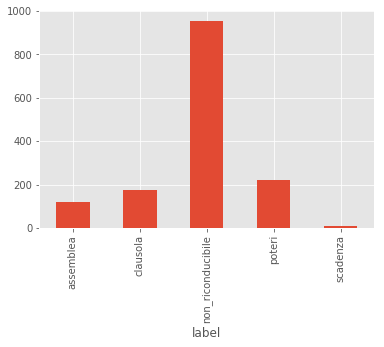

In [153]:
#dfx.groupby(['filename', 'label']).count()
dfx.groupby('label').count()['filename'].plot.bar()
#dfx.loc[dfx['label'] != 'non_riconducibile'].groupby('label').count()['filename'].plot.pie()

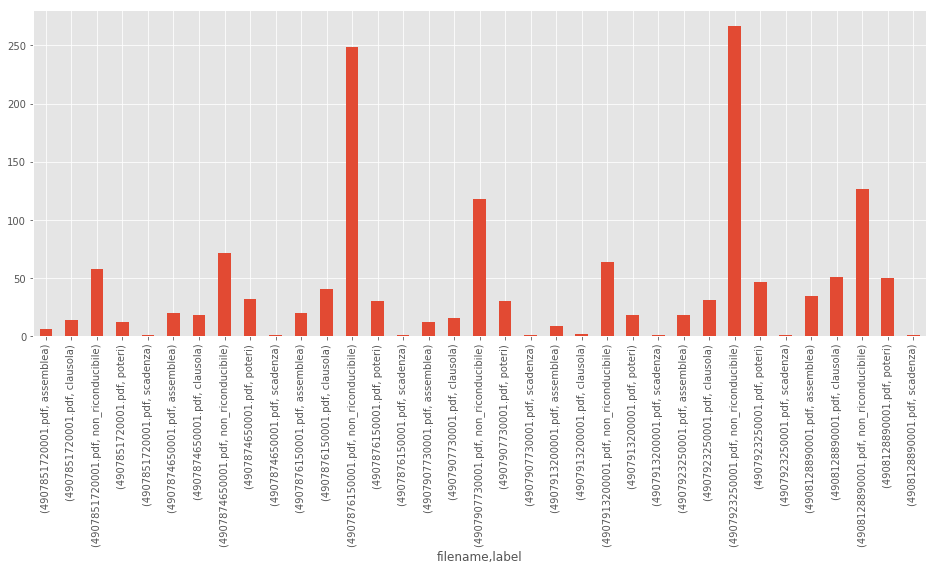

In [169]:
dfx.groupby(['filename','label'])['label'].count().plot.bar(figsize=(16,6))

In [143]:
dfx.to_csv('../extraction/merged_xlsx.csv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE, index=False)

## Experiments on labelled sentences

In [3]:
def cosine_similarity(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

def splitted_words_lower(sentences):
    return [[w.lower() for w in wd.splitted_words_utf8(s)] for s in sentences]


In [144]:
labeled_csv_filename = '../extraction/merged_xlsx.csv' #'../extraction/sentence_manual_labels3.csv'

ldf = pd.read_csv(labeled_csv_filename, sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

In [145]:
ldf.groupby('label').count()

,filename,sent_index,sentence
label,,,
assemblea,120,120,120
clausola,173,173,173
non_riconducibile,955,955,955
poteri,219,219,219
scadenza,7,7,7


In [146]:
labels = ['poteri', 'scadenza', 'assemblea', 'clausola']

sentences_rows = {l:ldf.loc[ldf['label'] == l]['sentence'] for l in labels}

splits = {l:splitted_words_lower(sentences_rows[l]) for l in labels}

In [147]:
def word_counts(sentences):
    d = dict()
    for sentence in sentences:
        for word in sentence:
            if not word in d:
                d[word] = 1
            else:
                d[word] += 1
    return d

def first_n_words(sentences, n):
    wc = word_counts(sentences)
    sorted_wc = sorted(wc.items(), key=operator.itemgetter(1))
    return list(reversed([x for x in sorted_wc[-n:]]))


## Tf Idf


In [122]:
def tf(word, sentence):
    '''Term frequency in the sentence'''
    return sum(1 for w in sentence if w == word)/len(sentence)

def idf(word, documents):
    '''Inverse document frequency'''
    D = len(documents)
    den = 1+sum(1 for sentence in documents if word in sentence)
    return math.log(D/den)

def idf_memo(documents):
    '''Defines a memoized version of idf with the given set of documents'''
    word_idf = {}
    def memoized_idf(word):
        if not word in word_idf:
            word_idf[word] = idf(word, documents)
        return word_idf[word]
    return memoized_idf

def tf_idf(word, sentence, sentences):
    '''Simple tf-idf index'''
    return tf(word, sentence)*idf(word, sentences)

def tf_idf_memo(documents):
    '''Defines a memoized version of tf-idf with the given set of documents'''
    idf_memoized = idf_memo(documents)
    def tf_idf_memoized(word, sentence):
        return tf(word, sentence)*idf_memoized(word)
    return tf_idf_memoized
    

In [148]:
# On all sentences
split_sentences = [[w.lower() for w in wd.splitted_words_utf8(s)] for s in ldf['sentence']]
tf_idf_memoized = tf_idf_memo(split_sentences)

In [149]:
def sorted_tfidf_words(splitted_sentences , tf_idf_memoized):
    words = set(word for sent in splitted_sentences for word in sent)
    words_mean_tfidf = [(word, np.mean([tf_idf_memoized(word, s) for s in splitted_sentences])) for word in words]
    return sorted(words_mean_tfidf, key=operator.itemgetter(1), reverse=True)

In [150]:
sorted_words = {k:sorted_tfidf_words(v, tf_idf_memoized) for k,v in splits.items()}


In [151]:
def print_parole_tf_idf(sorted_words, n = -1):
    print(u'{:20}\t{:20}\n'.format(u'parola',u'mean tf-idf'))
    if n < 0:
        n = len(sorted_words)
    for w, score in sorted_words[:n]:
        print(u'{:20}\t{:1.4f}'.format(w,score))

In [152]:
for k,v in sorted_words.items():
    print('{}:'.format(k))
    print_parole_tf_idf(v, 20)
    print()

assemblea:
parola              	mean tf-idf         

assemblea           	0.0766
l                   	0.0361
convocazione        	0.0305
dell                	0.0268
anche               	0.0245
convocata           	0.0225
essere              	0.0211
delega              	0.0202
verbale             	0.0201
deve                	0.0191
o                   	0.0190
soci                	0.0187
dal                 	0.0186
presidente          	0.0182
voto                	0.0173
che                 	0.0169
e                   	0.0168
dei                 	0.0168
per                 	0.0167
la                  	0.0164

clausola:
parola              	mean tf-idf         

recesso             	0.0446
diritto             	0.0422
socio               	0.0397
prelazione          	0.0287
il                  	0.0286
partecipazione      	0.0268
della               	0.0250
la                  	0.0234
del                 	0.0229
società             	0.0219
esercitato          	0.0217
esclusione          	0.0

In [134]:
most_relevant_poteri_words = OrderedDict(sorted_words['poteri']) #[:8]

In [135]:
def score_sentence_frequency(sentence, most_relevant_words):
    '''cosine distance between frequency of words in sentence and the most relevant words tf-idf'''
    counts = OrderedDict((w, 0) for w in most_relevant_words.keys())
    for w in sentence:
        if w in counts:
            counts[w] += 1
    l = len(sentence)
    frequencies = [v/l for v in counts.values()]
    if np.linalg.norm(frequencies) == 0 or np.linalg.norm(most_relevant_words.values()) == 0:
        return 0
    return cosine_similarity(np.array(frequencies), np.array(most_relevant_words.values())) 
    
def score_sentence_tf_idf(sentence, most_relevant_words, tf_idf_memoized):
    '''cosine distance between tf-idf of words in sentence and the most relevant words tf-idf'''
    tfidfs = OrderedDict((w, 0) for w in most_relevant_words.keys())
    for w in sentence:
        tfidfs[w] = tf_idf_memoized(w, sentence)
    if np.linalg.norm(tfidfs.values()) == 0 or np.linalg.norm(most_relevant_words.values()) == 0:
        return 0
    l = min(len(tfidfs), len(most_relevant_words))
    return cosine_similarity(np.array(tfidfs.values())[:l], np.array(most_relevant_words.values())[:l])

In [136]:
[score_sentence_tf_idf(split, OrderedDict(sorted_words['poteri']), tf_idf_memoized) for split in splits['poteri']]

[0.25926527663137583,
 0.1430480380630795,
 0.19433980044946894,
 0.13916291796054067,
 0.13630137787175242,
 0.27905714646701257,
 0.33748890398906622,
 0.29757622638982756,
 0.22781375782931532,
 0.20360503131344332,
 0.17855152303203395,
 0.25208098753884584,
 0.2144264916375111,
 0.28223810246895209,
 0.26478057059977939,
 0.25301990381111489,
 0.17285235341583943,
 0.34118623083111266,
 0.26315422154925139,
 0.32351705203787789,
 0.33235640999494936,
 0.35721936693635425,
 0.24494843426682048,
 0.21558137712746286,
 0.26479407237749575,
 0.29453800069174052,
 0.35401380641725944,
 0.19309306761231576,
 0.22903837288630363,
 0.14756841284530392,
 0.26946510685661584,
 0.17639030057904212,
 0.30450798165093906,
 0.23088558220939756,
 0.19956974089823901,
 0.33374579153543882,
 0.23283265339808379,
 0.24689922294988861,
 0.30058125959897408,
 0.24079090669383751,
 0.32261901919604496,
 0.2194880587683892,
 0.30174864790735795,
 0.25853545632218133,
 0.21294486160550741,
 0.2404907603

## Embeddings test

In [ ]:
txts_tokenized = [wd.tokenize_doc(txt) for txt in txts]

In [ ]:
reduced_dictionary_filename = 'first_5000_words.json'
with open(reduced_dictionary_filename) as f:
    reduced_dictionary = set(json.load(f))

gensim_model_filename = 'models/gensim_model_5000.d2v'
gensim_model = Doc2Vec.load(gensim_model_filename)

In [ ]:
embeddings = [em.embed_document(gensim_model, txt, reduced_dictionary) for txt in txts_tokenized]

In [ ]:
sv = partial(em.sentence_vector, model=gensim_model, permitted_words=reduced_dictionary)

In [ ]:
p1 = u'All\'organo amministrativo sono conferiti i più ampi poteri, sia per la gestione ordinaria che straordinaria della Società'
p2 = u'ARTICOLO 19 - POTERI DELL\'ORGANO AMMINISTRATIVO 191 L\'organo amministrativo ha tutti i poteri di ordinaria e straordinaria amministrazione'
cosine_similarity(sv(sentence=p1.lower()),sv(sentence=p2.lower())) 

In [ ]:
mean_cosines_poteri = [np.mean([cosine_similarity(sv(sentence=split_poteri[i]), sv(sentence=split_poteri[j]))
                               for i in range(len(split_poteri)) if i != j])
                                   for j in range(len(split_poteri))]

In [ ]:
mean_cosines_poteri

## Word2Vec


In [ ]:
sentences_tokenized = [sent for doc in txts_tokenized for sent in doc] #i should reduce the dictionary also

In [ ]:
w2v = Word2Vec(sentences_tokenized, size=100, window=5, min_count=5, workers=4)

In [ ]:
w2v.wv['costitutivo']

In [ ]:
cosine_similarity(w2v.wv['atto'], w2v.wv['costitutivo'])

In [ ]:
w2v.most_similar('poteri')

In [ ]:
w2v.most_similar(positive=['atto','costitutivo'])